In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [2]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt

In [3]:
from itertools import permutations

In [4]:
import seaborn as sns

In [5]:
from keras.datasets import mnist
from sklearn.manifold import TSNE

In [6]:
from sklearn.svm import SVC

In [7]:
from DataLoader import DataLoader

In [8]:
import visualkeras

In [ ]:
im_size = 96
channels = 3
flat_dim = im_size*im_size*channels
n_classes = 5 # we get rid of Ns as we have only 5 examples

In [10]:
# load Fabra
data = DataLoader("ViT")
data.load_data("/Users/marcosplazagonzalez/Desktop/Ground-based_CloudClassification/Datasets/FabraSwimcatClean_TrainTest/train", im_size, channels)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]


In [31]:
from sklearn.model_selection import train_test_split

# split into train and validation
x_train, x_test, y_train, y_test = train_test_split(data.X, data.y, test_size=0.3, random_state=42)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [32]:
x_train.shape

(474, 96, 96, 3)

### We need to do data augmentation

In [71]:
uniq, counts = np.unique(y_train, return_counts=True)

In [72]:
for i in range(len(uniq)):
    print(data.class_names[i], " => label ", uniq[i], " => samples ", counts[i])

Pattern  => label  0  => samples  38
Sky  => label  1  => samples  106
Thick Dark  => label  2  => samples  131
Thick White  => label  3  => samples  68
Veil  => label  4  => samples  39


In [73]:
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

def data_aug(src_X, height=96, width=96, channels=3, n_times=1):
    datagen = ImageDataGenerator(
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.75,1.35], # brightness
        zoom_range=[0.75,1.0]) # zoom

    # fit parameters from data
    datagen.fit(src_X)

    N = src_X.shape[0]
    X = np.zeros((N*n_times, height, width, channels))
    
    for n in range(n_times):
        for X_batch in datagen.flow(src_X, batch_size=N):
            for i in tqdm(range(0, N)):
                X[N*n+i,:,:,:] = X_batch[i]/255. # normalize images
            break

    return X

In [20]:
X_tmp = []
y_tmp = []
        
avoid = [0]

for idx, cl in enumerate(np.unique(data.y)):
    X_n = x_train[np.where(y_train == cl)[0]]
    if cl not in avoid: 
        if cl == 1 or cl == 2 or cl == 3:
            X_n = data_aug(X_n, n_times=5)
        else:
            X_n = data_aug(X_n, n_times=2)
    X_tmp.append(X_n)
    y_aug_tmp = np.zeros((X_n.shape[0], 1))
    y_aug_tmp += cl
    y_tmp.append(y_aug_tmp)

x_train = np.concatenate(X_tmp, axis=0)
y_train = np.concatenate(y_tmp, axis=0).astype('int32')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 27466.99it/s]


In [21]:
print(x_train.shape)
print(x_test.shape)

(2377, 96, 96, 3)
(459, 96, 96, 3)


In [22]:
from sklearn.utils import shuffle

y_train = y_train.flatten()
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [23]:
uniq, counts = np.unique(y_train, return_counts=True)

In [24]:
uniq

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [26]:
for i in range(len(uniq)):
    print(data.class_names[i], " => label ", uniq[i], " => samples ", counts[i])

Ac  => label  0  => samples  251
As  => label  1  => samples  215
Cb  => label  2  => samples  345
Cc  => label  3  => samples  250
Ci  => label  4  => samples  318
Cu  => label  5  => samples  382
Sc  => label  6  => samples  326
St  => label  7  => samples  290


### End data augmentation

In [33]:
# Define our own plot function
def scatter(x, labels, n_classes, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_classes))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(5):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i,:], axis=0) #np.median(x[np.where((labels == i).all(axis=1))[0]], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [34]:
x_train_flat = x_train.reshape(-1,flat_dim)
x_test_flat = x_test.reshape(-1,flat_dim)

/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


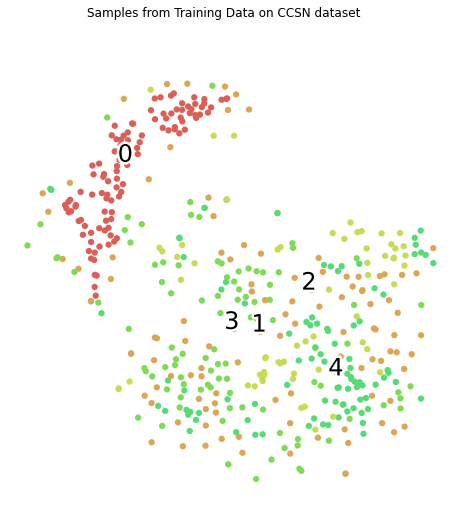

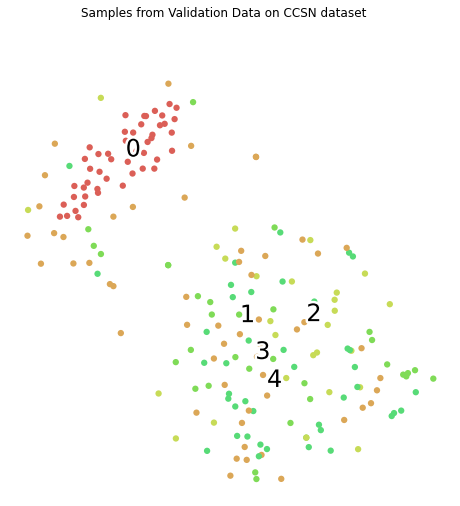

In [35]:
tsne = TSNE()

train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], n_classes, "Samples from Training Data on CCSN dataset")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], n_classes, "Samples from Validation Data on CCSN dataset")

### One-hot encoding of labels

In [36]:
from sklearn.preprocessing import LabelBinarizer

In [37]:
le = LabelBinarizer()

In [38]:
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)

### Triplet generation

In [39]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in np.unique(data_xy[1]):
        
        same_class_idx = np.where(data_xy[1] == data_class)[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        
        A_P_pairs = random.sample(list(permutations(same_class_idx, 2)), k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        
        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [40]:
X_train, X_test = generate_triplet(x_train_flat, y_train, testsize=0.2, ap_pairs=50, an_pairs=50)

In [41]:
print("Triplets in train {}".format(X_train.shape[0]))
print("Triplets in test {}".format(X_test.shape[0]))

Triplets in train 10000
Triplets in test 2500


## Triplet NN

In [42]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [43]:
def create_base_network(in_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    #model.add(Conv2D(128,(7,7),padding='same',input_shape=(in_dims[0],in_dims[1],in_dims[2],),activation='relu',name='conv1'))
    #model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool1'))
    #model.add(Conv2D(256,(5,5),padding='same',activation='relu',name='conv2'))
    #model.add(MaxPooling2D((2,2),(2,2),padding='same',name='pool2'))
    #model.add(Flatten(name='flatten'))
    #model.add(Dense(150,name='embeddings')) # ojo con los embeddings de esta dimension...
    
    # 1st Convolutional Layer
    model.add(Conv2D(filters=64, input_shape=(in_dims[0],in_dims[1],in_dims[2],), kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', name='conv1'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', name='pool1'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', name='conv2'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool2'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv3'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', name='conv4'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name='pool3'))

    # Passing it to a dense layer
    model.add(Flatten(name='flatten'))

    # Add Dropout to prevent overfitting
    #model.add(Dropout(0.5))

    # Dense Layer
    model.add(Dense(units=128, activation='relu')) # antes con 256
    # model.add(Dense(600))
    
    return model

In [44]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [45]:
anchor_input = Input((im_size,im_size,channels, ), name='anchor_input')
positive_input = Input((im_size,im_size,channels, ), name='positive_input')
negative_input = Input((im_size,im_size,channels, ), name='negative_input')

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([im_size,im_size,channels,])


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          232512      anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [47]:
Anchor = X_train[:,0,:].reshape(-1,im_size,im_size,channels)
Positive = X_train[:,1,:].reshape(-1,im_size,im_size,channels)
Negative = X_train[:,2,:].reshape(-1,im_size,im_size,channels)
Anchor_test = X_test[:,0,:].reshape(-1,im_size,im_size,channels)
Positive_test = X_test[:,1,:].reshape(-1,im_size,im_size,channels)
Negative_test = X_test[:,2,:].reshape(-1,im_size,im_size,channels)

In [48]:
Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

In [49]:
model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=50)

2022-06-30 20:45:48.422495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-30 20:45:48.428148: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(None, 384), dtype=float32)
y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(None, 384), dtype=float32)


2022-06-30 20:45:48.757188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.2609y_pred.shape =  Tensor("model_1/merged_layer/concat:0", shape=(None, 384), dtype=float32)


2022-06-30 20:46:01.747306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 15s 622ms/step - loss: 0.2609 - val_loss: 0.2543
Epoch 2/50
20/20 [==============================] - 7s 340ms/step - loss: 0.1772 - val_loss: 0.2001
Epoch 3/50
20/20 [==============================] - 8s 387ms/step - loss: 0.1236 - val_loss: 0.1824
Epoch 4/50
20/20 [==============================] - 6s 301ms/step - loss: 0.0828 - val_loss: 0.1852
Epoch 5/50
20/20 [==============================] - 6s 302ms/step - loss: 0.0549 - val_loss: 0.1778
Epoch 6/50
20/20 [==============================] - 6s 301ms/step - loss: 0.0369 - val_loss: 0.1796
Epoch 7/50
20/20 [==============================] - 6s 298ms/step - loss: 0.0244 - val_loss: 0.2000
Epoch 8/50
20/20 [==============================] - 5s 267ms/step - loss: 0.0166 - val_loss: 0.2090
Epoch 9/50
20/20 [==============================] - 5s 276ms/step - loss: 0.0104 - val_loss: 0.2051
Epoch 10/50
20/20 [==============================] - 6s 303ms/step - loss: 0.0065 - val_loss: 0.2002
Epoch 11/

In [50]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [51]:
#trained_model.save_weights("./Models/test18_ccsn_triplet_model.h5")
trained_model.save_weights("./Models/test20_triplet_fabraclouds.h5")
print("Saved model to disk")

Saved model to disk


In [52]:
tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,im_size,im_size,channels))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,im_size,im_size,channels))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)

2022-06-30 20:50:38.546391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/marcosplazagonzalez/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


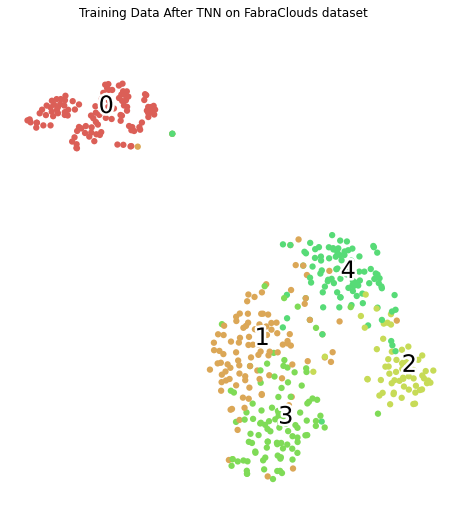

In [53]:
scatter(train_tsne_embeds, y_train[:512], n_classes, "Training Data After TNN on FabraClouds dataset")

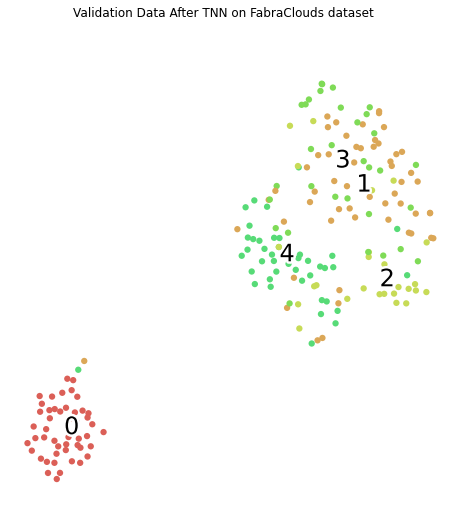

In [54]:
scatter(eval_tsne_embeds, y_test[:512], n_classes, "Validation Data After TNN on FabraClouds dataset")

### Training a classifier once we have the embeddings

In [57]:
X_train_trm = trained_model.predict(x_train.reshape(-1,im_size,im_size,channels))
X_test_trm = trained_model.predict(x_test.reshape(-1,im_size,im_size,channels))

Classifier_input = Input((128,))
Classifier_output = Dense(5, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm, y_train_onehot, validation_data=(X_test_trm,y_test_onehot), epochs=500)

Epoch 1/500
 1/15 [=>............................] - ETA: 3s - loss: 1.7556 - accuracy: 0.2188

2022-06-30 20:52:42.836164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 17ms/step - loss: 1.7189 - accuracy: 0.1097 - val_loss: 1.6254 - val_accuracy: 0.0980
Epoch 2/500
15/15 [==============================] - 0s 8ms/step - loss: 1.6002 - accuracy: 0.1582 - val_loss: 1.5524 - val_accuracy: 0.2451
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 1.5594 - accuracy: 0.0938

2022-06-30 20:52:43.168852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 9ms/step - loss: 1.5324 - accuracy: 0.2236 - val_loss: 1.5003 - val_accuracy: 0.2941
Epoch 4/500
15/15 [==============================] - 0s 8ms/step - loss: 1.4750 - accuracy: 0.4409 - val_loss: 1.4561 - val_accuracy: 0.5196
Epoch 5/500
15/15 [==============================] - 0s 8ms/step - loss: 1.4267 - accuracy: 0.6055 - val_loss: 1.4146 - val_accuracy: 0.5784
Epoch 6/500
15/15 [==============================] - 0s 9ms/step - loss: 1.3804 - accuracy: 0.6730 - val_loss: 1.3815 - val_accuracy: 0.6029
Epoch 7/500
15/15 [==============================] - 0s 9ms/step - loss: 1.3366 - accuracy: 0.6857 - val_loss: 1.3406 - val_accuracy: 0.6324
Epoch 8/500
15/15 [==============================] - 0s 9ms/step - loss: 1.2941 - accuracy: 0.7089 - val_loss: 1.3086 - val_accuracy: 0.6275
Epoch 9/500
15/15 [==============================] - 0s 9ms/step - loss: 1.2542 - accuracy: 0.7278 - val_loss: 1.2764 - val_accuracy: 0.6569
Epoch 10/500
15/15 [=====

Epoch 61/500
15/15 [==============================] - 0s 9ms/step - loss: 0.5315 - accuracy: 0.8608 - val_loss: 0.7412 - val_accuracy: 0.7402
Epoch 62/500
15/15 [==============================] - 0s 9ms/step - loss: 0.5273 - accuracy: 0.8608 - val_loss: 0.7379 - val_accuracy: 0.7402
Epoch 63/500
15/15 [==============================] - 0s 9ms/step - loss: 0.5239 - accuracy: 0.8608 - val_loss: 0.7364 - val_accuracy: 0.7451
Epoch 64/500
15/15 [==============================] - 0s 9ms/step - loss: 0.5202 - accuracy: 0.8586 - val_loss: 0.7340 - val_accuracy: 0.7402
Epoch 65/500
15/15 [==============================] - 0s 9ms/step - loss: 0.5162 - accuracy: 0.8586 - val_loss: 0.7322 - val_accuracy: 0.7402
Epoch 66/500
15/15 [==============================] - 0s 8ms/step - loss: 0.5129 - accuracy: 0.8608 - val_loss: 0.7303 - val_accuracy: 0.7402
Epoch 67/500
15/15 [==============================] - 0s 8ms/step - loss: 0.5093 - accuracy: 0.8608 - val_loss: 0.7287 - val_accuracy: 0.7402
Epoch 

15/15 [==============================] - 0s 9ms/step - loss: 0.4108 - accuracy: 0.8734 - val_loss: 0.6866 - val_accuracy: 0.7402
Epoch 119/500
15/15 [==============================] - 0s 9ms/step - loss: 0.4108 - accuracy: 0.8776 - val_loss: 0.6879 - val_accuracy: 0.7353
Epoch 120/500
15/15 [==============================] - 0s 8ms/step - loss: 0.4087 - accuracy: 0.8755 - val_loss: 0.6848 - val_accuracy: 0.7500
Epoch 121/500
15/15 [==============================] - 0s 9ms/step - loss: 0.4079 - accuracy: 0.8734 - val_loss: 0.6841 - val_accuracy: 0.7549
Epoch 122/500
15/15 [==============================] - 0s 10ms/step - loss: 0.4068 - accuracy: 0.8734 - val_loss: 0.6855 - val_accuracy: 0.7500
Epoch 123/500
15/15 [==============================] - 0s 10ms/step - loss: 0.4061 - accuracy: 0.8734 - val_loss: 0.6845 - val_accuracy: 0.7353
Epoch 124/500
15/15 [==============================] - 0s 9ms/step - loss: 0.4048 - accuracy: 0.8755 - val_loss: 0.6857 - val_accuracy: 0.7304
Epoch 125/5

15/15 [==============================] - 0s 8ms/step - loss: 0.3646 - accuracy: 0.8776 - val_loss: 0.6750 - val_accuracy: 0.7451
Epoch 176/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3644 - accuracy: 0.8776 - val_loss: 0.6761 - val_accuracy: 0.7451
Epoch 177/500
15/15 [==============================] - 0s 9ms/step - loss: 0.3632 - accuracy: 0.8797 - val_loss: 0.6745 - val_accuracy: 0.7402
Epoch 178/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3629 - accuracy: 0.8819 - val_loss: 0.6739 - val_accuracy: 0.7402
Epoch 179/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3623 - accuracy: 0.8819 - val_loss: 0.6742 - val_accuracy: 0.7402
Epoch 180/500
15/15 [==============================] - 0s 9ms/step - loss: 0.3621 - accuracy: 0.8840 - val_loss: 0.6743 - val_accuracy: 0.7402
Epoch 181/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3622 - accuracy: 0.8797 - val_loss: 0.6757 - val_accuracy: 0.7402
Epoch 182/500

15/15 [==============================] - 0s 8ms/step - loss: 0.3376 - accuracy: 0.8819 - val_loss: 0.6703 - val_accuracy: 0.7451
Epoch 233/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3384 - accuracy: 0.8861 - val_loss: 0.6676 - val_accuracy: 0.7402
Epoch 234/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3364 - accuracy: 0.8840 - val_loss: 0.6694 - val_accuracy: 0.7451
Epoch 235/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3369 - accuracy: 0.8797 - val_loss: 0.6703 - val_accuracy: 0.7451
Epoch 236/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3362 - accuracy: 0.8840 - val_loss: 0.6681 - val_accuracy: 0.7451
Epoch 237/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3353 - accuracy: 0.8840 - val_loss: 0.6682 - val_accuracy: 0.7451
Epoch 238/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3349 - accuracy: 0.8840 - val_loss: 0.6694 - val_accuracy: 0.7451
Epoch 239/500

15/15 [==============================] - 0s 8ms/step - loss: 0.3178 - accuracy: 0.8840 - val_loss: 0.6643 - val_accuracy: 0.7500
Epoch 290/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3179 - accuracy: 0.8840 - val_loss: 0.6630 - val_accuracy: 0.7451
Epoch 291/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3171 - accuracy: 0.8861 - val_loss: 0.6636 - val_accuracy: 0.7451
Epoch 292/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3171 - accuracy: 0.8840 - val_loss: 0.6654 - val_accuracy: 0.7500
Epoch 293/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3168 - accuracy: 0.8819 - val_loss: 0.6649 - val_accuracy: 0.7500
Epoch 294/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3170 - accuracy: 0.8840 - val_loss: 0.6650 - val_accuracy: 0.7451
Epoch 295/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3161 - accuracy: 0.8819 - val_loss: 0.6619 - val_accuracy: 0.7500
Epoch 296/500

15/15 [==============================] - 0s 8ms/step - loss: 0.3023 - accuracy: 0.8861 - val_loss: 0.6598 - val_accuracy: 0.7451
Epoch 347/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3029 - accuracy: 0.8882 - val_loss: 0.6607 - val_accuracy: 0.7451
Epoch 348/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3019 - accuracy: 0.8882 - val_loss: 0.6587 - val_accuracy: 0.7451
Epoch 349/500
15/15 [==============================] - 0s 9ms/step - loss: 0.3019 - accuracy: 0.8924 - val_loss: 0.6582 - val_accuracy: 0.7451
Epoch 350/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3018 - accuracy: 0.8903 - val_loss: 0.6589 - val_accuracy: 0.7451
Epoch 351/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3018 - accuracy: 0.8903 - val_loss: 0.6590 - val_accuracy: 0.7451
Epoch 352/500
15/15 [==============================] - 0s 8ms/step - loss: 0.3012 - accuracy: 0.8882 - val_loss: 0.6597 - val_accuracy: 0.7451
Epoch 353/500

15/15 [==============================] - 0s 8ms/step - loss: 0.2901 - accuracy: 0.8924 - val_loss: 0.6553 - val_accuracy: 0.7451
Epoch 404/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2907 - accuracy: 0.8966 - val_loss: 0.6545 - val_accuracy: 0.7451
Epoch 405/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2899 - accuracy: 0.8966 - val_loss: 0.6558 - val_accuracy: 0.7500
Epoch 406/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2896 - accuracy: 0.8924 - val_loss: 0.6562 - val_accuracy: 0.7500
Epoch 407/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2895 - accuracy: 0.8924 - val_loss: 0.6555 - val_accuracy: 0.7500
Epoch 408/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2893 - accuracy: 0.8924 - val_loss: 0.6554 - val_accuracy: 0.7451
Epoch 409/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2890 - accuracy: 0.8924 - val_loss: 0.6560 - val_accuracy: 0.7451
Epoch 410/500

15/15 [==============================] - 0s 8ms/step - loss: 0.2801 - accuracy: 0.8966 - val_loss: 0.6531 - val_accuracy: 0.7500
Epoch 461/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2803 - accuracy: 0.8966 - val_loss: 0.6539 - val_accuracy: 0.7451
Epoch 462/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2804 - accuracy: 0.8987 - val_loss: 0.6504 - val_accuracy: 0.7549
Epoch 463/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2796 - accuracy: 0.8987 - val_loss: 0.6521 - val_accuracy: 0.7500
Epoch 464/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2798 - accuracy: 0.8945 - val_loss: 0.6524 - val_accuracy: 0.7500
Epoch 465/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2792 - accuracy: 0.8945 - val_loss: 0.6523 - val_accuracy: 0.7500
Epoch 466/500
15/15 [==============================] - 0s 8ms/step - loss: 0.2791 - accuracy: 0.8987 - val_loss: 0.6512 - val_accuracy: 0.7500
Epoch 467/500

In [58]:
# load test data
#testdata = DataLoader("ViT")
#testdata.load_data("/Users/marcosplazagonzalez/Desktop/Ground-based_CloudClassification/Datasets/FabraSwimcatClean_TrainTest/test", im_size, channels)

# predict with the trained_model (triplet loss model) to obtain the embeddings
X_datatest_trm = trained_model.predict(x_test.reshape(-1,im_size,im_size,channels))

# once we have the embeddings (flattened matrices of dimension 100) we have to do the predict with the last classifier
y_pred = Classifier_model.predict(X_datatest_trm)

2022-06-30 20:53:44.863883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [59]:
y_test_onehot

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [60]:
y_predonehot = le.fit_transform(y_pred.argmax(axis=1))

In [61]:
y_predonehot

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [62]:
len(y_test_onehot[1])

5

In [63]:
len(y_predonehot[1])

5

In [64]:
n = 0
total = y_test_onehot.shape[0]
for i in range(total):
    if (y_test_onehot[i] == y_predonehot[i]).all():
        n += 1
        
n / total

0.75

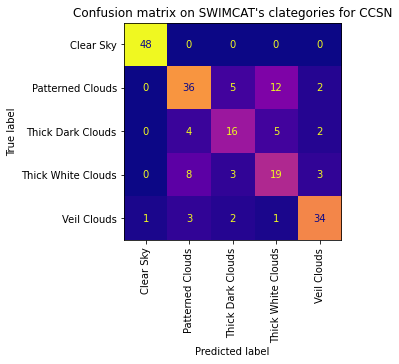

In [65]:
# todo reformar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

matrix = confusion_matrix(y_test_onehot.argmax(axis=1), y_predonehot.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=data.class_names)
disp.plot(colorbar=False, cmap='plasma', xticks_rotation='vertical')
plt.title("Confusion matrix on SWIMCAT's clategories for CCSN")
plt.show()